# Прогнозирование временного ряда с использованием Prophet


---


## Описание данных

Используется открытый датасет Daily Minimum Temperatures in Melbourne.

Размер датасета: 3650 наблюдений.

Грануляция времени: 1 день.


---


### Подготовим нужные библиотеки

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # это библиотека для управления warning'ами — то есть различными предупреждениями
                # ниже мы с помощью нее игнорим лишние предупреждения
                # мы можем это убрать, но где-то всплывали ворнинги, и чтобы они не раздражали и не вызывали вопросов, мы их отключим

warnings.filterwarnings('ignore')

### Графический анализ данных
Для начала посмотрим на данные — какие есть поля, объем данных и т. д.

In [ ]:
df = pd.read_csv(
    'daily-minimum-temperatures-in-me.csv',
    on_bad_lines='skip' #так как в данных есть строка с описанием и вылезает ошибка, мы её исключаем.
)

print(df.head())
df.shape


         Date Daily minimum temperatures in Melbourne, Australia, 1981-1990
0  1981-01-01                                               20.7           
1  1981-01-02                                               17.9           
2  1981-01-03                                               18.8           
3  1981-01-04                                               14.6           
4  1981-01-05                                               15.8           


(3650, 2)

В наших данных есть информация о температуре в Мельбурне (Австралия) за каждый день с 1 января 1981 по 31 декабря 1990. Получается 2 стобца (дата и температура) и 3650 строк данных.

###Проверка


Проверим данные на наличие дубликатов, пропущенных значений в важных  для расчёта столбцах.

In [ ]:
print(f"Дубликаты: {df.duplicated().sum()}")

print(f"Строки с пропусками: {df.isnull().sum()}")

Дубликаты: 0
Строки с пропусками: Date                                                             0
Daily minimum temperatures in Melbourne, Australia, 1981-1990    0
dtype: int64


0 строка содержит описание (требуется переименовать 2 столбец) а так пропущенные значения и дубликаты в важных столбцах отсутствуют.

###Оценка

Так как размер временного ряда 3650 дней, то размер прогноза будет 365 дней (10%).

###Выбор локатора времени

Выберем годичный (для общей картины) и месячный (увидеть лучше повторяющиеся циклы и сезонность). Недельные и меньше смысла нету для такого большого количества данных.

###Визуализируем данные целиком, чтобы посмотреть на них.

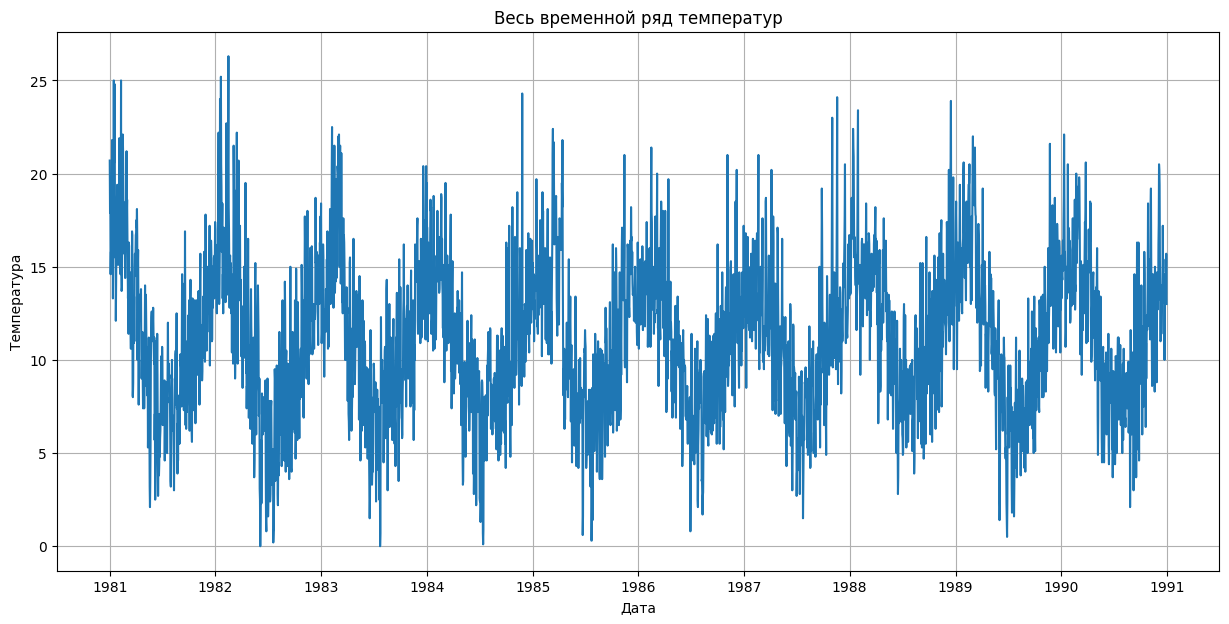

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['Date', 'Temp'] #не забываем переименовать 2 столбец
df = df.sort_values('Date').reset_index(drop=True)

df['Temp'] = df['Temp'].astype(str).str.replace('?', '', regex=False) #пару строк содержали ? из за чего диаграммы ломались
df['Temp'] = pd.to_numeric(df['Temp'])

plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Temp'])
plt.title('Весь временной ряд температур')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid(True)

plt.show()

Уже понятно что есть цикличность, чтобы лучше увидеть это построим кажому году свою диаграмму.

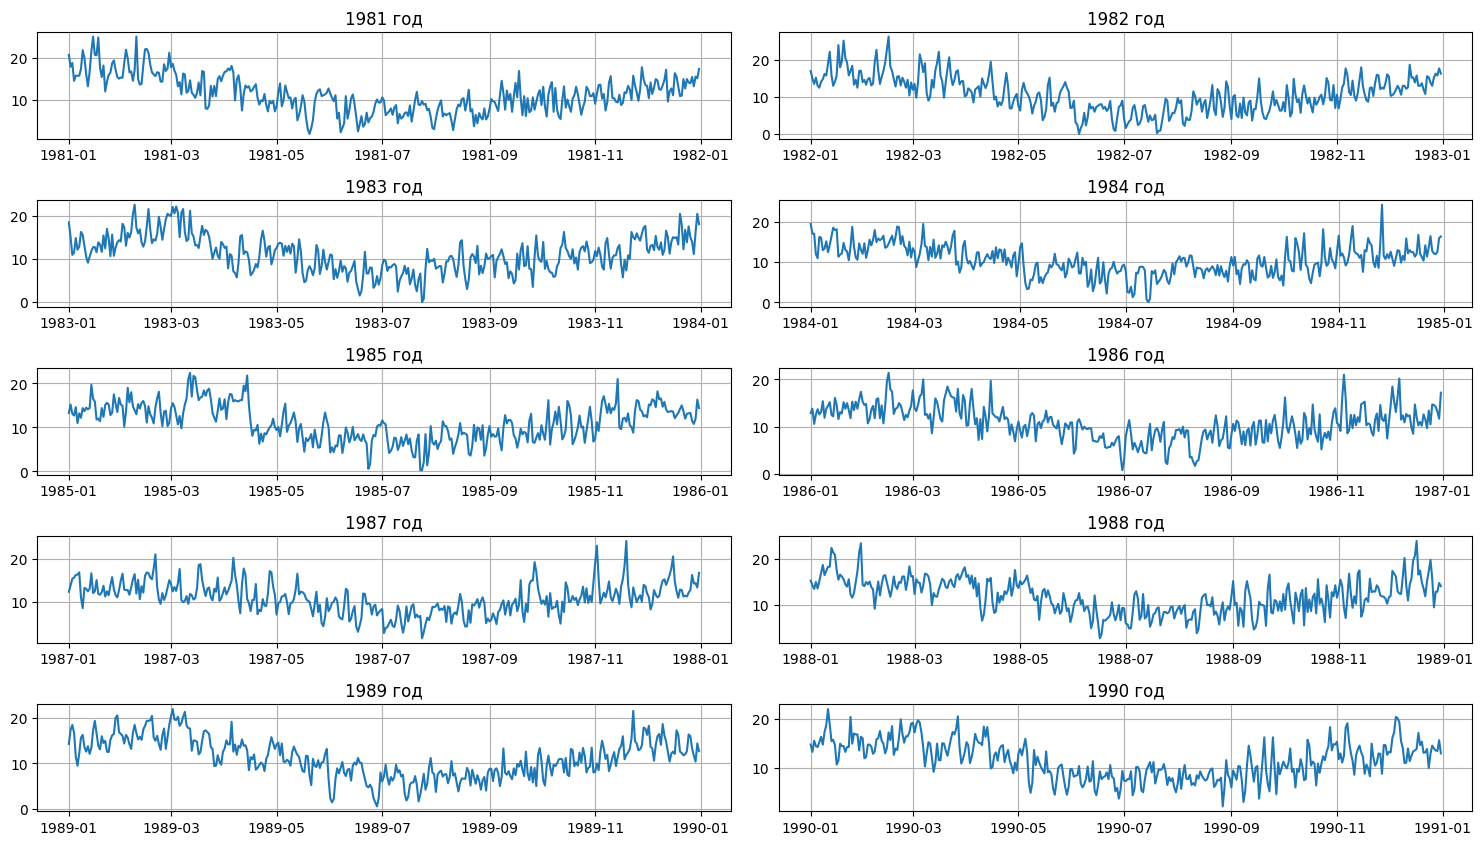

In [ ]:
years = df['Date'].dt.year.unique()
plt.figure(figsize=(15, 10))

for i, year in enumerate(years, 1):
    plt.subplot(len(years)//2 + 1, 2, i)
    df_year = df[df['Date'].dt.year == year]
    plt.plot(df_year['Date'], df_year['Temp'])
    plt.title(f'{year} год')
    plt.grid(True)

plt.tight_layout()
plt.show()

Теперь лучше видно, что каждый год начинается с относительного понижения температур с колебаниями и примерно с 9 месяца начинается повышение тоже с колебаниями.

### Временной ряд с годовым локатором
Для анализа общей динамики временного ряда используем годовой локатор времени.


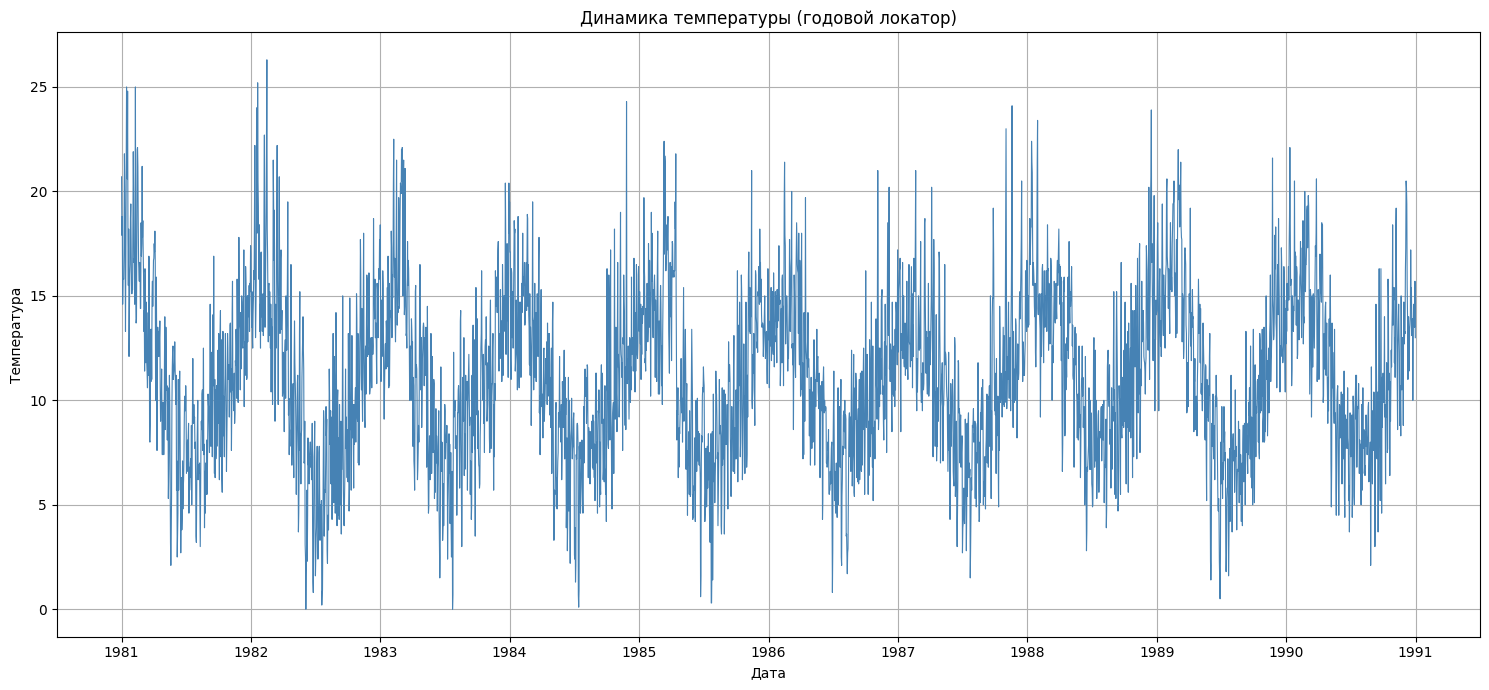

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 7))
plt.title('Динамика температуры (годовой локатор)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid()

plt.plot(df['Date'], df['Temp'], linewidth=0.8, color='steelblue')

locator = mdates.YearLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.show()

Опять видна та же сезонность с начала каждого года и в конце, чтобы лучше это увидеть надо построить месячный локатор.

### Временной ряд с месячным локатором

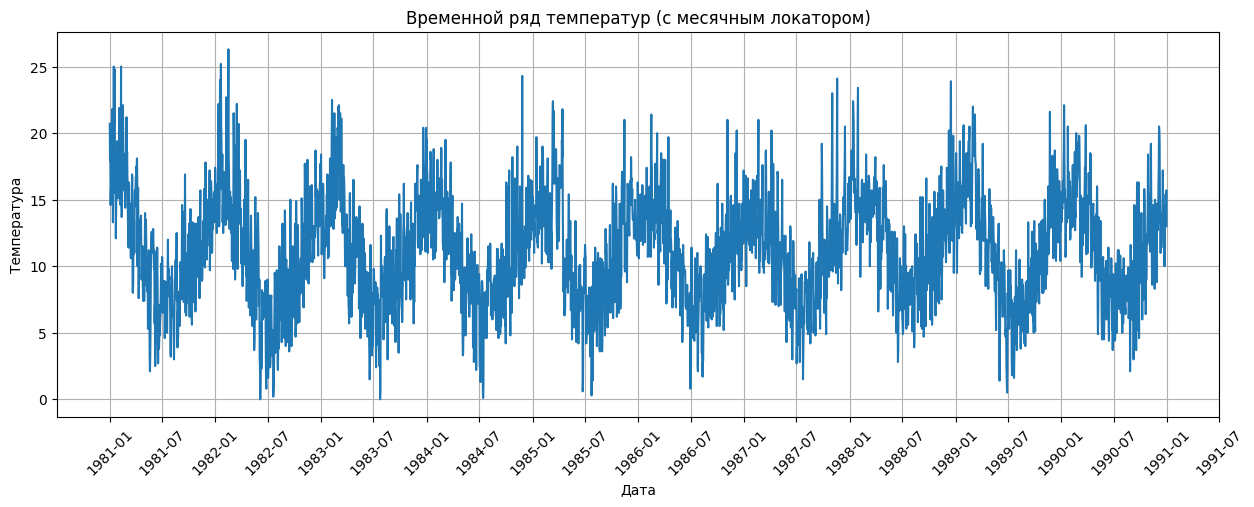

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Temp'])

plt.title('Временной ряд температур (с месячным локатором)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid(True)

locator = mdates.MonthLocator(interval=6)#чтобы даты не сливались
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)

plt.show()

Наблюдаем лучше циклический характер данных(с 1 месяца по 7 месяц каждого года идёт понижение температур, а далее с 7 месяца до примерно 2 месяца Нового года идёт повышение температуры). Разделим данные раздельно по годам для лучшего выявления повторяющихся паттернов.

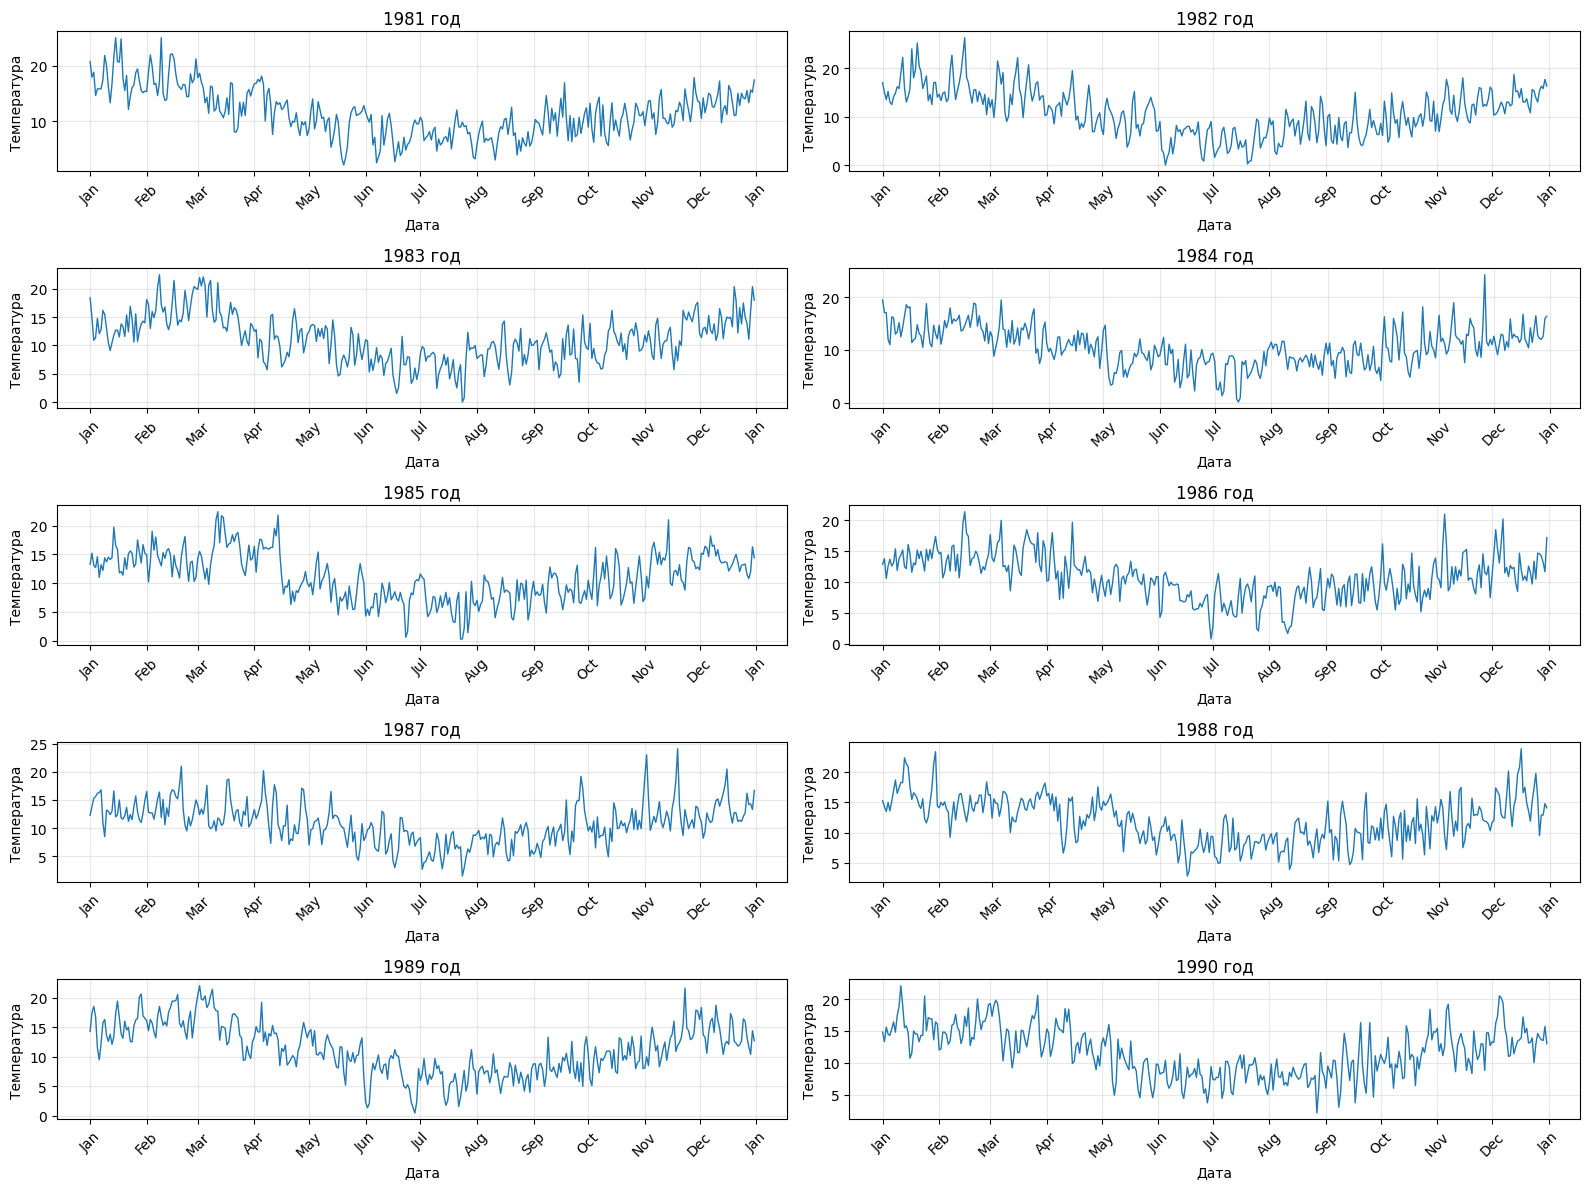

In [ ]:
df['Year'] = df['Date'].dt.year
years = df['Year'].unique()

plt.figure(figsize=(16, 12))

for i, year in enumerate(years, 1):
    plt.subplot(5, 2, i)
    year_data = df[df['Year'] == year]
    plt.plot(year_data['Date'], year_data['Temp'], linewidth=1)
    plt.title(f'{year} год')
    plt.xlabel('Дата')
    plt.ylabel('Температура')
    plt.grid(alpha=0.3)

    locator = mdates.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Теперь лучше видна сезонность (с начала года понижение температур с колебаниями, летом температура более менее фиксируется на одном уровне, с осени начинается повышение с колебаниями).

###Вывод

На основании графического анализа данных можно сделать следующие вывод , что временной ряд минимальных температур имеет выраженную сезонную структуру и значительные колебания значений.

###Гипотеза

Отсюда следует что при обучение модели стоит учитывать сезонность.

###Контрольная и тестовая выборка

In [ ]:
df_prophet = df.rename(columns={
    'Date': 'ds',
    'Temp': 'y'
})

split_date = df_prophet['ds'].quantile(0.9)

train = df_prophet[df_prophet['ds'] <= split_date]
test  = df_prophet[df_prophet['ds'] > split_date]


Таким образом, для обучения модели используется контрольная выборка длительностью 9 лет (90%), а для оценки качества прогноза — тестовая выборка длительностью 1 год (10%).

###Предварительный прогноз

In [ ]:
from prophet import Prophet

model = Prophet()
model.fit(train)

future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Давайте дополнительно проверим визуально этот прогноз на адекватность.

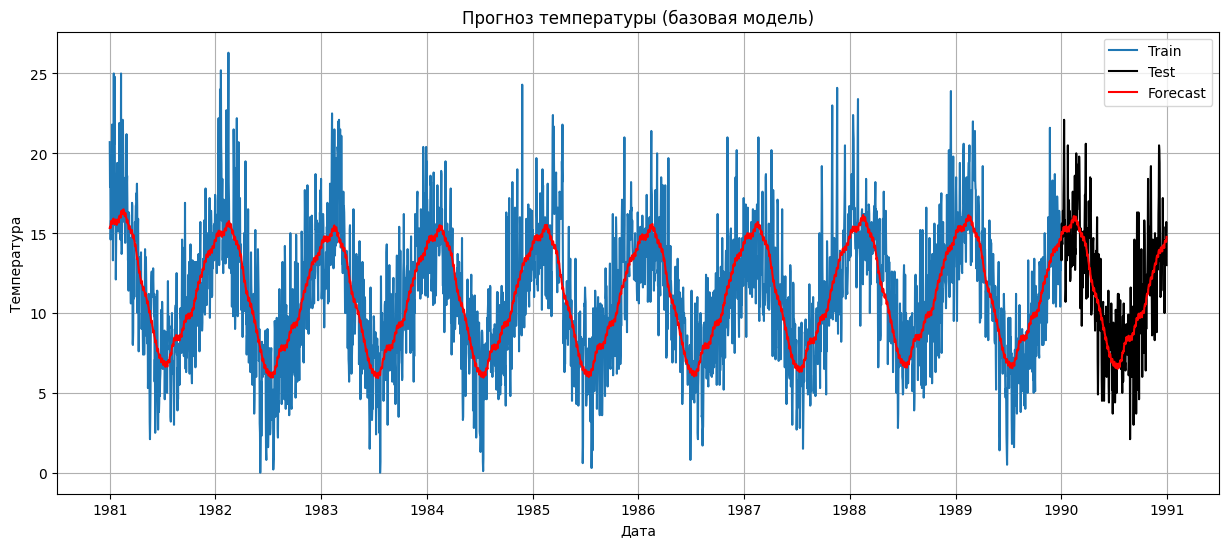

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')

plt.title('Прогноз температуры (базовая модель)')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.grid(True)
plt.show()

И рассчитаем ошибку.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = test['y'].values
y_pred = forecast.tail(len(test))['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1.94
RMSE: 2.52


MAE (средняя абсолютная ошибка): 1.94

RMSE (квадратный корень из средней квадратичной ошибки): 2.52

Таким образом отклонения в среднем составляет 2°C что уже хорошо, но можно попытаться уменьшить эти значения если учесть сезонность.

###Обучение с учётом сезонности

In [ ]:
model_season = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model_season.fit(train)

Учитываем только годовую сезонность, так как наши данные это позволяют.

In [ ]:
future = model_season.make_future_dataframe(periods=len(test))
forecast_season = model_season.predict(future)

y_true = test['y'].values
y_pred = forecast_season.tail(len(test))['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5

print(f"MAE (с сезонностью): {mae:.2f}")
print(f"RMSE (с сезонностью): {rmse:.2f}")

MAE (с сезонностью): 1.93
RMSE (с сезонностью): 2.51


MAE (средняя абсолютная ошибка): 1.93

RMSE (квадратный корень из средней квадратичной ошибки): 2.51

Как мы видим значение практически неизменились, но такая ошибка уже является нормальной для построение прогноза.

##Финальное обучение

Теперь, когда модель выбрана, надо перестроить модель по всему набору данных и сделать на следующий год:

In [ ]:
df_full = df[['Date', 'Temp']].rename(columns={
    'Date': 'ds',
    'Temp': 'y'
})

final_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

final_model.fit(df_full)

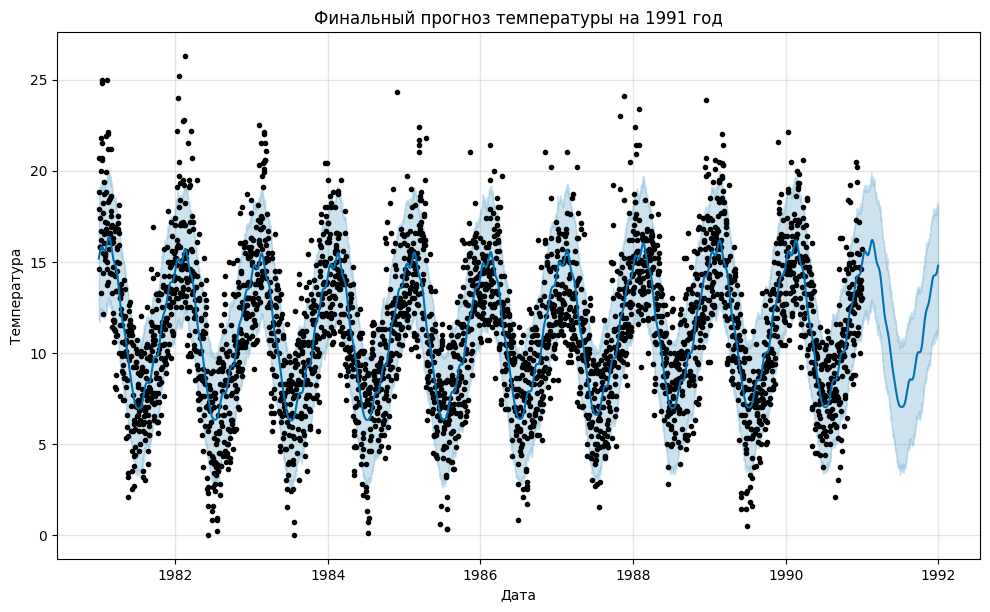

In [ ]:
future = final_model.make_future_dataframe(periods=365)
final_forecast = final_model.predict(future)

fig = final_model.plot(final_forecast)
plt.title('Финальный прогноз температуры на 1991 год')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.grid(True)
plt.show()

Таким образом, спрогнозировали температуру на следующий год (365 дней) с помощью обученной модели, учитывающей сезонность.

## Спасибо за внимание
    